<a href="https://colab.research.google.com/github/eshal26/Convolutional-Neural-Networks/blob/main/xception_2fc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
#importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import shutil
import sklearn
from sklearn.model_selection import train_test_split


In [37]:
train_dir = 'train_dataset'
val_dir = 'validation_dataset'
test_dir = 'test_dataset'

# Define transformations for training, validation, and testing data
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.8245, 0.8547, 0.9387], std = [0.1323, 0.1431, 0.0530])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.8245, 0.8547, 0.9387], std = [0.1323, 0.1431, 0.0530])
])

# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [38]:
import torch
import torch.nn as nn

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class SimplifiedXception(nn.Module):
    def __init__(self, num_classes=2):
        super(SimplifiedXception, self).__init__()
        self.flow = nn.Sequential(
            DepthwiseSeparableConv(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Dropout layers
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)

        # Adaptive pooling to fix the output size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=64, out_features=32)  # First FC layer with 32 units
        self.fc2 = nn.Linear(in_features=32, out_features=num_classes)  # Second FC layer for final output

    def forward(self, x):
        x = self.flow(x)
        x = self.dropout1(x)

        # Adaptive pooling and flattening
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)  # Flatten the tensor

        # Pass through the fully connected layers with ReLU activation
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimplifiedXception(num_classes=2).to(device)

print(model)


SimplifiedXception(
  (flow): Sequential(
    (0): DepthwiseSeparableConv(
      (depthwise): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3)
      (pointwise): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


In [39]:
from collections import Counter
import numpy as np

all_labels = [label for _, label in train_dataset]
all_labels = np.array(all_labels)


unique_labels, counts = np.unique(all_labels, return_counts=True)
print(f"Unique Labels: {unique_labels}")
print(f"Counts: {counts}")

# Calculate class weights
num_samples = len(all_labels)
num_classes = len(unique_labels)
class_counts = Counter(all_labels)
class_weights = {class_id: num_samples / (num_classes * count) for class_id, count in class_counts.items()}
class_weights_tensor = torch.tensor([class_weights[i] for i in range(num_classes)], dtype=torch.float32)

print(f"Class Weights: {class_weights}")
print(f"Class Weights Tensor: {class_weights_tensor}")

Unique Labels: [0 1]
Counts: [ 403 2201]
Class Weights: {0: 3.230769230769231, 1: 0.5915492957746479}
Class Weights Tensor: tensor([3.2308, 0.5915])


In [40]:
from torch.optim import lr_scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [41]:
num_epochs = 40

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {train_loss:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%")


Epoch 1/40, Training Loss: 0.7078, Validation Loss: 0.6439, Validation Accuracy: 59.38%
Epoch 2/40, Training Loss: 0.6636, Validation Loss: 0.6383, Validation Accuracy: 52.00%
Epoch 3/40, Training Loss: 0.6326, Validation Loss: 0.6151, Validation Accuracy: 65.23%
Epoch 4/40, Training Loss: 0.6073, Validation Loss: 0.5944, Validation Accuracy: 71.08%
Epoch 5/40, Training Loss: 0.5779, Validation Loss: 0.5907, Validation Accuracy: 69.54%
Epoch 6/40, Training Loss: 0.5578, Validation Loss: 0.5500, Validation Accuracy: 76.62%
Epoch 7/40, Training Loss: 0.5404, Validation Loss: 0.5463, Validation Accuracy: 75.38%
Epoch 8/40, Training Loss: 0.5327, Validation Loss: 0.5078, Validation Accuracy: 79.08%
Epoch 9/40, Training Loss: 0.5177, Validation Loss: 0.5083, Validation Accuracy: 78.77%
Epoch 10/40, Training Loss: 0.4996, Validation Loss: 0.4974, Validation Accuracy: 78.77%
Epoch 11/40, Training Loss: 0.4818, Validation Loss: 0.4750, Validation Accuracy: 80.31%
Epoch 12/40, Training Loss: 0.

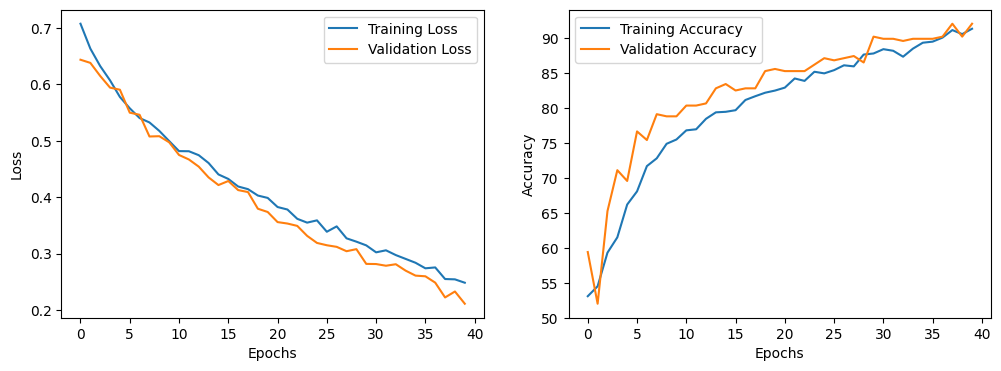

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Test Loss: 0.2707
Test Accuracy: 0.8930
Test Precision: 0.9216
Test Recall: 0.8930
Test F1-score: 0.9010
Confusion Matrix:
 [[ 46   5]
 [ 30 246]]


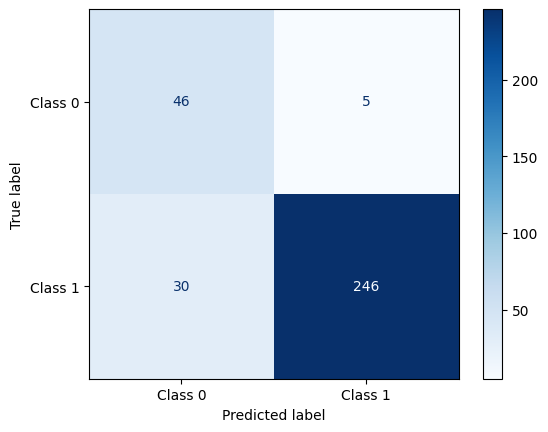

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.61      0.90      0.72        51
     Class 1       0.98      0.89      0.93       276

    accuracy                           0.89       327
   macro avg       0.79      0.90      0.83       327
weighted avg       0.92      0.89      0.90       327



In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, accuracy_score

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    test_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get the predicted labels
            _, preds = torch.max(outputs, 1)

            # Convert predictions and labels to numpy for metrics calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Compute loss
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

    # Compute average test loss
    test_loss /= len(dataloader.dataset)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1-score: {f1:.4f}')

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    class_report = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1'])
    print("Classification Report:\n", class_report)

    return test_loss, accuracy, precision, recall, f1, cm, class_report

test_loss, test_accuracy, test_precision, test_recall, test_f1, cm, class_report = evaluate_model(model, test_loader, criterion, device)

In [45]:
torch.save(model, '/content/drive/MyDrive/custom_xception_2fc.pth')